<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/PUBG-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2900","key":"013d0652e9b9eb4019f031ca190f5741"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Mar 21 02:09 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# List available datasets.
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          15635  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          18002  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          13380  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           3035  
bigquery/crypto-ethereum-classic                          

In [6]:
!kaggle competitions download -c pubg-finish-placement-prediction

 53% 9.00M/16.9M [00:00<00:00, 12.2MB/s]
100% 16.9M/16.9M [00:00<00:00, 24.7MB/s]
 90% 88.0M/98.3M [00:02<00:00, 23.8MB/s]
100% 98.3M/98.3M [00:02<00:00, 37.9MB/s]
 97% 232M/239M [00:06<00:00, 38.9MB/s]
100% 239M/239M [00:06<00:00, 41.1MB/s]


In [7]:
!unzip train_V2.csv.zip
!unzip test_V2.csv.zip
!unzip sample_submission_V2.csv.zip

Archive:  train_V2.csv.zip
  inflating: train_V2.csv            
Archive:  test_V2.csv.zip
  inflating: test_V2.csv             
Archive:  sample_submission_V2.csv.zip
  inflating: sample_submission_V2.csv  


In [0]:
import pandas as pd
import matplotlib
import pydot
import re
import dask.dataframe as dd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import numpy as np
import seaborn as sns
sns.set()
import sklearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

import gc
gc.enable()

In [0]:
train_df_raw = pd.read_csv('train_V2.csv')
test_df_raw = pd.read_csv('test_V2.csv')

In [0]:
def draw_missing_data_table(df):
  total = df.isnull().sum().sort_values(ascending = False)
  percent = (df.isnull().sum()/ df.isnull().count()).sort_values(ascending= False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  return missing_data


In [49]:
draw_missing_data_table(path_train)

,Total,Percent
winPlacePerc,1,2.248724e-07
longestKill,0,0.000000e+00
groupId,0,0.000000e+00
matchId,0,0.000000e+00
assists,0,0.000000e+00
boosts,0,0.000000e+00
damageDealt,0,0.000000e+00
DBNOs,0,0.000000e+00
headshotKills,0,0.000000e+00
heals,0,0.000000e+00


In [50]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


**### With those data we can see that one feature will need to be modified : the matchType feature. Indeed, any other features are already numerical and the Id related features are not taken into account for feature engineering.**

In [51]:
train_df_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


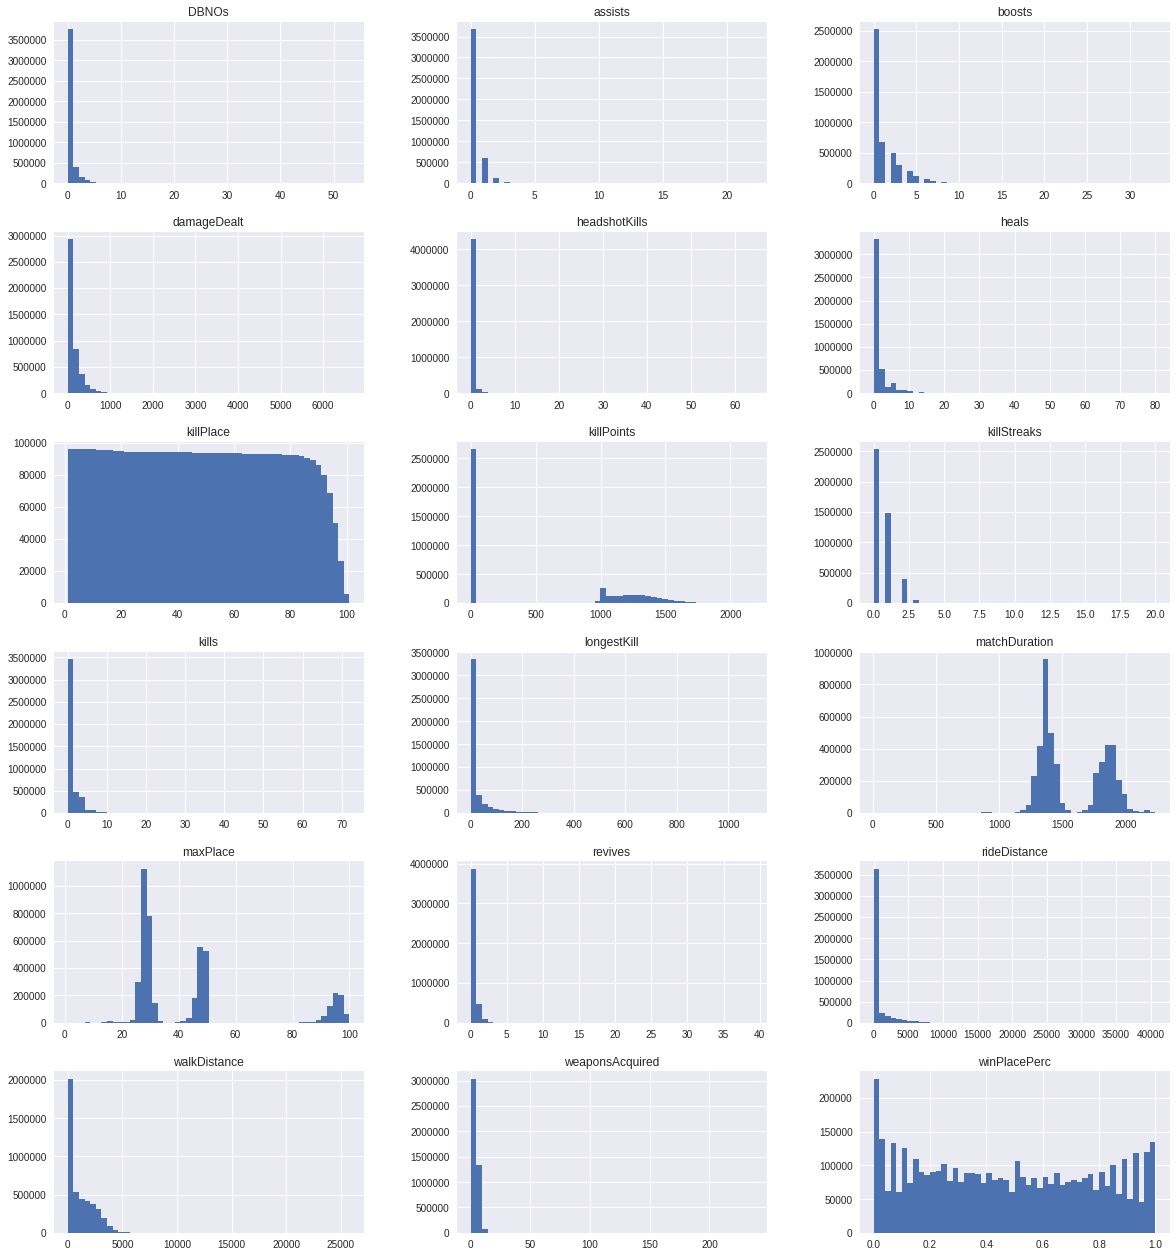

In [52]:
train_df_raw.drop(['Id', 'groupId', 'matchId', 'winPoints', 'rankPoints',
                   'teamKills', 'vehicleDestroys', 'roadKills', 
                   'swimDistance', 'numGroups'], 1).hist(
    bins=50, figsize=(20,30), layout=(8, 3))
plt.show()

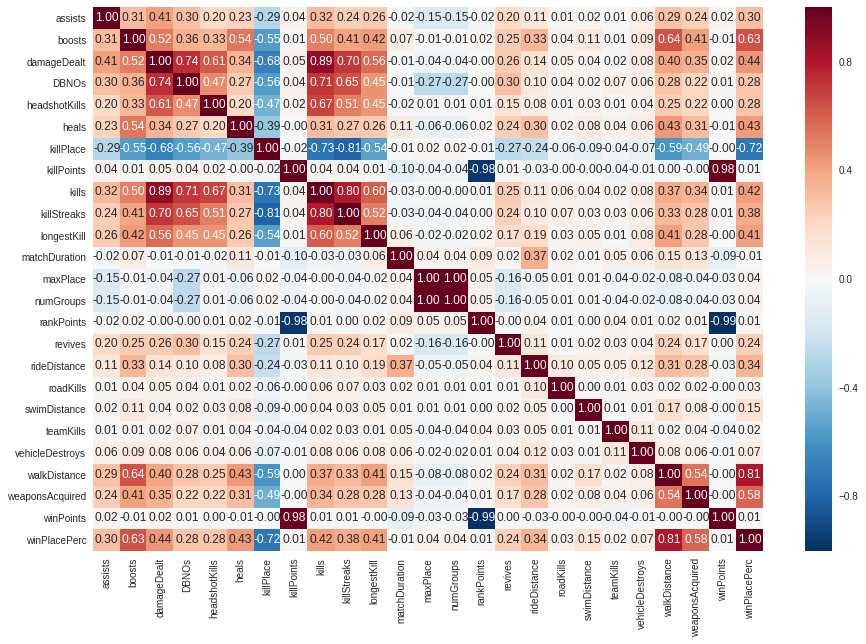

In [53]:
plt.figure(figsize=(15,10))  
sns.heatmap(train_df_raw.corr(), annot=True, fmt=".2f")
plt.show()

### With this first simple data exploration, we can observe that :

* Majority of players have no kills at the end of the game (same conclusion for assists)
* Players who killed other players have between 1 and 10 kills (maximum in almost all cases, same conclusion for assists)
* Walk distance do not exeed 7000-8000 meters.
* We can identify low importance variables which are almost always zero: swim distance, vehicle destroyed, roadkills
* Teamkills are extremely rare but we can assume that when a player killed a teamate, it compromised a lot his placement so this variable can be relevant
* The killplace variable seem to show a strong correlation between placement and number of enemy players killed for the 0 to 90 placements and a decorrelation for the end of the placements (top 10 players).
* The final classement if well distributed between 0 and 100, with a majority of 0 probably consequence of early leaving of players.
* winPoints and killpoints seems to be redundant, indeed, players who are doing the biggest number of kills often win their games. We may delete one of those columns.
* obviously, damage dealt is strongly correlated withs number of kills, but not enought to delete one of those columns
* No other strong correlation can be spotted

In [54]:
train_df_raw.matchType.unique().tolist()

['squad-fpp',
 'duo',
 'solo-fpp',
 'squad',
 'duo-fpp',
 'solo',
 'normal-squad-fpp',
 'crashfpp',
 'flaretpp',
 'normal-solo-fpp',
 'flarefpp',
 'normal-duo-fpp',
 'normal-duo',
 'normal-squad',
 'crashtpp',
 'normal-solo']

In [55]:
train_df_raw['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536762
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [0]:
def preprocess_data(df, with_categorical=False):

    processed_df = df.drop(['Id', 'rankPoints'],  axis=1)
            
    # handle matchType column by creating dummies cols or creating new categorical variable column
    print('-'*5 + ' handling matchType column ' + '-'*5)
    new_matchType_cols = list()
    if (with_categorical):
      for mtype in processed_df['matchType']:
        if mtype in ['squad', 'squad-fpp', 'normal-squad-fpp', 'normal-squad', 'flarefpp', 'flaretpp']:
          new_matchType_cols.append([3])
        elif mtype in ['solo', 'solo-fpp', 'normal-solo-fpp', 'normal-solo']:
          new_matchType_cols.append([1])
        else:
          new_matchType_cols.append([2])
      match_df = pd.DataFrame(new_matchType_cols,columns=['matchType'], index=processed_df.index)
    else:
      for mtype in processed_df['matchType']:
        if mtype in ['squad', 'squad-fpp', 'normal-squad-fpp', 'normal-squad', 'flarefpp', 'flaretpp']:
          new_matchType_cols.append([1, 0, 0])
        elif mtype in ['solo', 'solo-fpp', 'normal-solo-fpp', 'normal-solo']:
          new_matchType_cols.append([0, 0, 1])
        else:
          new_matchType_cols.append([0, 1, 0])
        match_df = pd.DataFrame(new_matchType_cols, columns=['squad','duo', 'solo'], index=processed_df.index)
    processed_df = processed_df.drop(['matchType'], axis = 1 )
    
    print('-'*5 + ' create matchSize column ' + '-'*5)
    match_size = processed_df.groupby(['matchId']).size().reset_index(name='matchSize')
    processed_df = processed_df.merge(match_size, how='left', on=['matchId'])
    
    return processed_df
    

In [64]:
preprocess_data(train_df_raw)

----- handling matchType column -----


ValueError: ignored